- Register env with ray.tune.registery
- training config
- can access policy with Algorithm.get_policy()
- check evaluation options in config
- check checkpoint options in config
- for fast env small model PPO: increase num_env_runners, maybe eneable vectorization for inference
- check batch size

In [9]:
from rleplus.examples.registry import register_all
register_all()

In [10]:
import ray
from ray import air, tune
from ray.rllib.algorithms.ppo import PPOConfig

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np

import torch

import random

In [11]:
env_setup = {
    "env": "BBrightEnv",
    "csv": False,
    "verbose": False,
    "output": "./tmp/episodes/",
    "num_workers": 1,
    "num_gpus": 0,
    "alg": "PPO",
    "use-lstm": True
}


config = (
    PPOConfig()
    .environment(
        env=env_setup["env"],
        env_config=env_setup,
    )
    .framework("torch")
    .training(
        gamma=0.95,
        lr=0.002,
        kl_coeff=0.3,
        train_batch_size=96,
        sgd_minibatch_size=96,
        vf_loss_coeff=0.01,
        use_critic=True,
        use_gae=True,
        model={
            "use_lstm": env_setup["use-lstm"],
            "vf_share_layers": False,
        },
        _enable_learner_api=True,
    )
    .rl_module(_enable_rl_module_api=True)
    .framework(
        # to use tensorflow, you'll need install it first,
        # then set framework="tf2" and eager_tracing=True (for fast exec)
        framework="torch",
    )
    .resources(num_gpus=env_setup["num_gpus"])
    .rollouts(
        num_rollout_workers=env_setup["num_workers"],
        rollout_fragment_length="auto",
    ) 
)

# set the seeds for reproducibility
seed = 4
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
config["seed"] = seed

In [12]:
ray.shutdown()

In [13]:
ray.init()

register_all()

algo = config.build()
results = []
for i in range(370):
    result = algo.train()
    results.append(result)

    if i % 10 == 0:
        checkpoint = algo.save(checkpoint_dir="./tmp/checkpoints/")
        print("checkpoint", i//10, "saved at", checkpoint)

ray.shutdown()

/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/_private/node.py:1308: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-11_15-28-22_367082_76698/logs/gcs_server.out' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/_private/node.py:1308: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-11_15-28-22_367082_76698/logs/gcs_server.err' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/_private/node.py:1313: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-11_15-28-22_367082_76698/logs/monitor.out' mode='a' encoding='utf-8'>
  self.start_monitor()
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/sit

KeyboardInterrupt: 

In [ ]:
# save results as a pkl file
with open("./tmp/training-results.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
# load results from a pkl file
with open("./tmp/training-results.pkl", "rb") as f:
    results = pkl.load(f)

In [ ]:
print(results[-1].keys())
print(results[-1]["info"].keys())
print(results[-1]["info"]["learner"].keys())
print(results[-1]["info"]["learner"]["default_policy"].keys())
print(results[-1]["info"]["learner"]["default_policy"])

dict_keys(['custom_metrics', 'episode_media', 'info', 'sampler_results', 'episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter', 'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'hist_stats', 'sampler_perf', 'num_faulty_episodes', 'connector_metrics', 'num_healthy_workers', 'num_in_flight_async_reqs', 'num_remote_worker_restarts', 'num_agent_steps_sampled', 'num_agent_steps_trained', 'num_env_steps_sampled', 'num_env_steps_trained', 'num_env_steps_sampled_this_iter', 'num_env_steps_trained_this_iter', 'num_env_steps_sampled_throughput_per_sec', 'num_env_steps_trained_throughput_per_sec', 'timesteps_total', 'num_steps_trained_this_iter', 'agent_timesteps_total', 'timers', 'counters', 'done', 'episodes_total', 'training_iteration', 'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore', 'perf'])
dict_keys(['learner', 'n

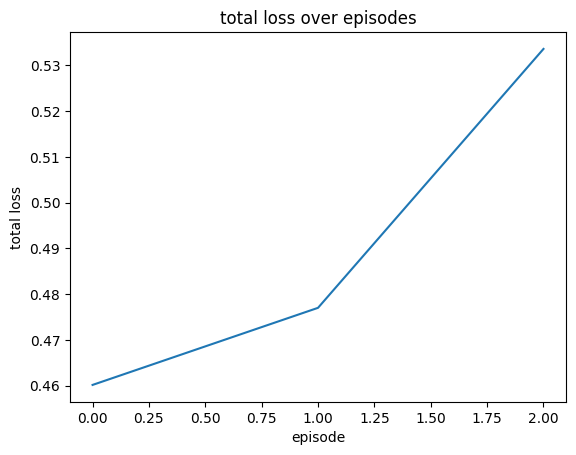

In [ ]:
# plot log loss over episodes
plt.plot([r["info"]["learner"]["default_policy"]['total_loss'] for r in results[2:]])
plt.xlabel("episode")
plt.ylabel("total loss")
plt.title("total loss over episodes")
# plt.yscale("log")

plt.show()

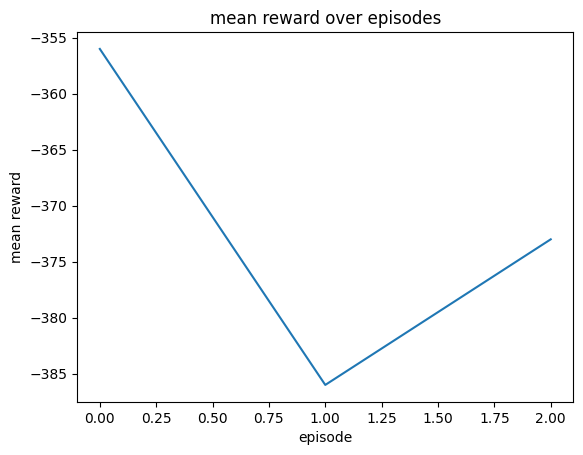

In [ ]:
# plot mean reward over each episode
plt.plot([r['episode_reward_mean'] for r in results[2:]])
plt.xlabel("episode")
plt.ylabel("mean reward")
plt.title("mean reward over episodes")
plt.show()

In [ ]:
# read the result pickle file
import pickle as pkl

episode_results = []
# Read the history from the pickle
with open('./tmp/history.pkl', 'rb') as f:
    while True:
        try:
            episode_results.append(pkl.load(f))
        except EOFError:
            break

print(episode_results[0].keys())
print(len(episode_results))

# combine the results of each episode
import numpy as np

combined_results = {}
for k in episode_results[0].keys():
    combined_results[k] = np.concatenate([r[k] for r in episode_results])

print(combined_results.keys())
print(len(combined_results['reward']))

dict_keys(['out_tmp', 'air_tmp', 'opr_tmp', 'air_hum', 'htg_stp', 'clg_stp', 'eeq_htg', 'air_chg', 'rad_tmp', 'reward', 'pmv'])
370
dict_keys(['out_tmp', 'air_tmp', 'opr_tmp', 'air_hum', 'htg_stp', 'clg_stp', 'eeq_htg', 'air_chg', 'rad_tmp', 'reward', 'pmv'])
35519


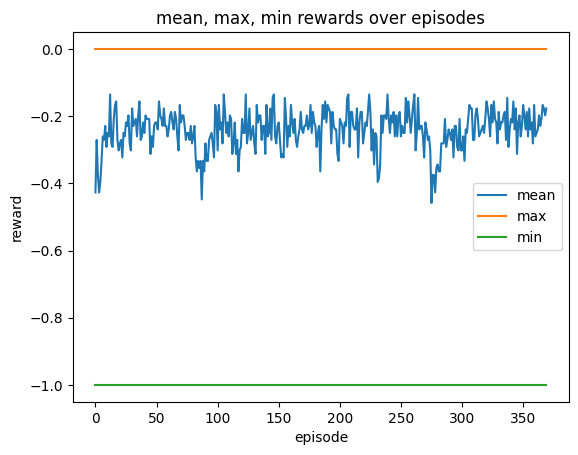

In [ ]:
# pad a zero at the beginning of the rewards to make it the same length as the actions
comb_rewards = np.concatenate([np.zeros(1), combined_results['reward']])
# comb_rewards = comb_rewards[1:]

# get the mean, max, min, std of the rewards per episode (96 time steps)
mean_rewards = np.mean(comb_rewards.reshape(-1, 96), axis=1)
max_rewards = np.max(comb_rewards.reshape(-1, 96), axis=1)
min_rewards = np.min(comb_rewards.reshape(-1, 96), axis=1)

# plot the mean, max, min rewards over episodes
plt.plot(mean_rewards, label='mean')
plt.plot(max_rewards, label='max')
plt.plot(min_rewards, label='min')
plt.legend()
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("mean, max, min rewards over episodes")
plt.show()

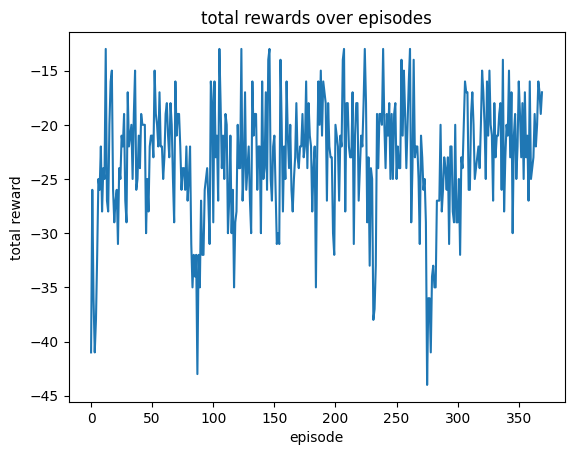

In [ ]:
# get the total rewards per episode (96 time steps)
total_rewards = np.sum(comb_rewards.reshape(-1, 96), axis=1)

# plot the total rewards over episodes
plt.plot(total_rewards)
plt.xlabel("episode")
plt.ylabel("total reward")
plt.title("total rewards over episodes")
plt.show()

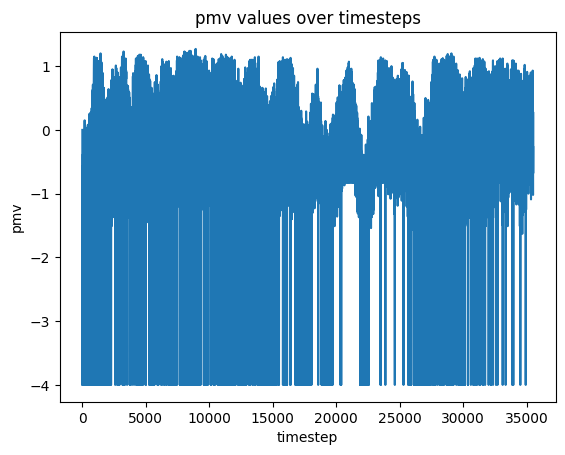

In [ ]:
# get the pmv values per timestep (96 time steps)
pmv_values = combined_results['pmv']
# pad a zero at the beginning of the pmv values to make it the same length as the actions
pmv_values = np.concatenate([np.zeros(1), pmv_values])
#replace the nan values with -4
pmv_values[np.isnan(pmv_values)] = -4


# plot the pmv values over timesteps
plt.plot(pmv_values)
plt.xlabel("timestep")
plt.ylabel("pmv")
plt.title("pmv values over timesteps")
plt.show()


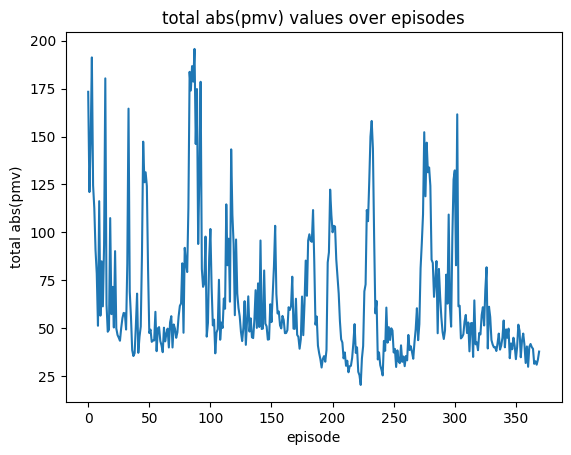

In [ ]:
# get the total absolute pmv values per episode (96 time steps)
total_pmv = np.sum(np.abs(pmv_values.reshape(-1, 96)), axis=1)

# plot the total pmv values over episodes
plt.plot(total_pmv)
plt.xlabel("episode")
plt.ylabel("total abs(pmv)")
plt.title("total abs(pmv) values over episodes")
plt.show()

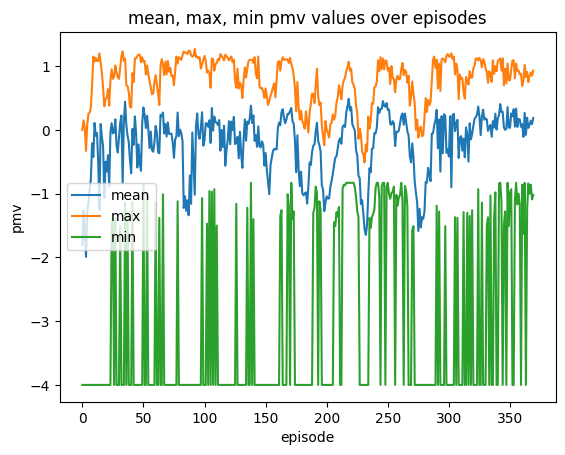

In [ ]:
# get the min, max, mean of the pmv values per episode (96 time steps)
mean_pmv = np.mean(pmv_values.reshape(-1, 96), axis=1)
max_pmv = np.max(pmv_values.reshape(-1, 96), axis=1)
min_pmv = np.min(pmv_values.reshape(-1, 96), axis=1)

# plot the mean, max, min pmv values over episodes
plt.plot(mean_pmv, label='mean')
plt.plot(max_pmv, label='max')
plt.plot(min_pmv, label='min')
plt.legend()
plt.xlabel("episode")
plt.ylabel("pmv")
plt.title("mean, max, min pmv values over episodes")
plt.show()

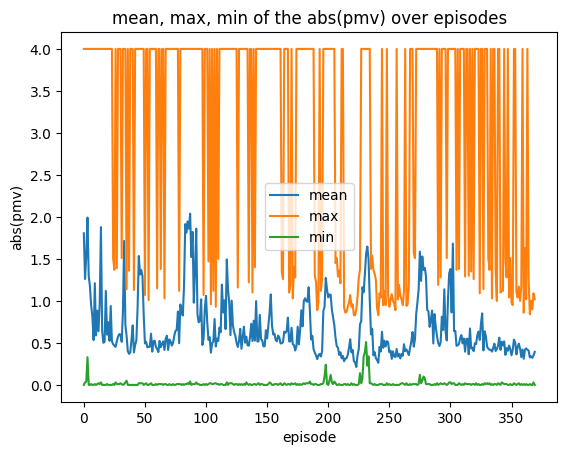

In [ ]:
# get the mean, max, min of the abs(pmv) per episode (96 time steps)
mean_abs_pmv = np.mean(np.abs(pmv_values).reshape(-1, 96), axis=1)
max_abs_pmv = np.max(np.abs(pmv_values).reshape(-1, 96), axis=1)
min_abs_pmv = np.min(np.abs(pmv_values).reshape(-1, 96), axis=1)

# plot the mean, max, min of the abs(pmv) over episodes
plt.plot(mean_abs_pmv, label='mean')
plt.plot(max_abs_pmv, label='max')
plt.plot(min_abs_pmv, label='min')
plt.legend()
plt.xlabel("episode")
plt.ylabel("abs(pmv)")
plt.title("mean, max, min of the abs(pmv) over episodes")
plt.show()